### TABLE CREATION

In [1]:
import warnings
from collections import Counter

import numpy as np
import pandas as pd
# from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from scipy.interpolate import NearestNDInterpolator
from scipy.ndimage import median_filter, gaussian_filter
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import silhouette_score
from tqdm import tqdm

from helper import *

In [2]:
data_train = pd.read_pickle("DamasconeA2.pkl")
data_validation = pd.read_pickle("DamasconeA.pkl")
data_test = pd.read_pickle("DamasconeB.pkl")


# TODO nan
# TODO highest in the center

In [3]:
data_train['stiffness_to_relaxation'] = data_train['Stiffness'] / data_train['force_relaxation']
data_train['oscillation_to_max_force'] = data_train['force_oscillation'] / data_train['force_max']

data_test['stiffness_to_relaxation'] = data_test['Stiffness'] / data_test['force_relaxation']
data_test['oscillation_to_max_force'] = data_test['force_oscillation'] / data_test['force_max']

data_validation['stiffness_to_relaxation'] = data_validation['Stiffness'] / data_validation['force_relaxation']
data_validation['oscillation_to_max_force'] = data_validation['force_oscillation'] / data_validation['force_max']

data_train = data_train.dropna()
data_test = data_test.dropna()
data_validation = data_validation.dropna()

In [4]:
to_remove = ['poly3_coef0', 'poly3_coef1', 'poly3_coef2', 'poly3_coef3',
             'poly4_coef0', 'poly4_coef1', 'poly4_coef2', 'poly4_coef3', 'poly4_coef4',
             'poly5_coef0', 'poly5_coef1', 'poly5_coef2', 'poly5_coef3', 'poly5_coef4',
             # Segmentation features
             'segment2_slope', 'segment3_slope', 'segment2_force_std', 'segment3_force_std',
             'segment2_skew', 'segment3_skew']

# feature_list2 = data_train.columns
#
feature_list_3 = feature_list = [x for x in feature_list2 + ['stiffness_to_relaxation', 'oscillation_to_max_force'] if
                                 x not in to_remove]


# feature_list = feature_list_3
# feature_list = ['loading_unloading_area_ratio', 'peak_width', 'stiffness_to_relaxation', 'Stiffness']
# feature_list = ["Stiffness", "Upstroke", "Downstroke", "P_ss"] #, "P_ss", "loading_energy"]peak_position
# feature_list = ['poly4_coef4', 'poly4_coef3', 'poly5_coef0', 'loading_unloading_area_ratio', 'Stiffness', 'quartic_coefficient', 'Upstroke']

In [5]:
data_train['peak_position'] = - data_train['peak_position']
data_test['peak_position'] = - data_test['peak_position']
data_validation['peak_position'] = - data_validation['peak_position']

### SPATIAL SMOOTHING

In [6]:
smoothing_config = {
    'Entropy': 'gaussian',
}  # Dictionary 'feature-name' : type of smoothing (set if you want to test other method of smoothing instead of median)


def apply_smoothing(grid_z, method='median'):
    if method == 'median':
        return median_filter(grid_z, size=3, mode='reflect')
    elif method == 'gaussian':
        return gaussian_filter(grid_z, sigma=2)
    elif method == 'diffusion':
        # Simple anisotropic diffusion
        def diffusion_step(img, kappa=50):
            # Compute image gradients
            dy, dx = np.gradient(img)

            # Compute diffusion coefficients
            diff_coef_x = 1 / (1 + (dx / kappa) ** 2)
            diff_coef_y = 1 / (1 + (dy / kappa) ** 2)

            # Compute diffusion
            diff_x = np.zeros_like(img)
            diff_y = np.zeros_like(img)

            diff_x[1:-1, 1:-1] = diff_coef_x[1:-1, 1:-1] * (img[1:-1, 2:] - img[1:-1, 1:-1])
            diff_y[1:-1, 1:-1] = diff_coef_y[1:-1, 1:-1] * (img[2:, 1:-1] - img[1:-1, 1:-1])

            return img + 0.25 * (diff_x + diff_y)

        # Apply multiple diffusion steps
        iterations = 20
        img = grid_z.copy()
        for i in range(iterations):
            img = diffusion_step(img)
        return img

    else:
        raise ValueError(f"Smoothing method not implemented: {method}")


def get_grid_bounds(df):
    x_min, x_max = int(df["posx"].min()), int(df["posx"].max())
    y_min, y_max = int(df["posy"].min()), int(df["posy"].max())
    grid_shape = (y_max - y_min + 1, x_max - x_min + 1)
    return x_min, y_min, grid_shape


# Smoothing function for a single dataframe
def smooth_subset(subset_df, x_min, y_min, grid_shape):
    smoothed_subset = pd.DataFrame(index=subset_df.index)

    for feature in feature_list:
        # Initialize grid with NaNs
        grid_z = np.full(grid_shape, np.nan, dtype=np.float32)

        # Map each data point to the grid
        for _, row in subset_df.iterrows():
            x_idx = int(row["posx"]) - x_min
            y_idx = int(row["posy"]) - y_min
            grid_z[y_idx, x_idx] = row[feature]

        # Interpolate missing values
        yy, xx = np.indices(grid_z.shape)
        valid_mask = ~np.isnan(grid_z)

        if np.any(~valid_mask):
            interpolator = NearestNDInterpolator(
                np.column_stack((yy[valid_mask], xx[valid_mask])),
                grid_z[valid_mask]
            )
            grid_z = interpolator(yy, xx)

        # Apply feature-specific smoothing
        methods = smoothing_config.get(feature,
                                       'median')  # Get the designed methods, if None select defaul 'median' method
        if isinstance(methods, list):
            for method in methods:
                grid_z = apply_smoothing(grid_z, method=method)
        else:
            grid_z = apply_smoothing(grid_z, method=methods)

        # Map smoothed grid back to DataFrame
        smoothed_subset[feature] = [
            grid_z[int(row["posy"]) - y_min, int(row["posx"]) - x_min]
            for _, row in subset_df.iterrows()
        ]

    # Add back metadata columns
    smoothed_subset[['label', 'posx', 'posy']] = subset_df[['label', 'posx', 'posy']]
    return smoothed_subset


if smoothing_config is None:
    smoothing_config = {feature: 'median' for feature in feature_list}

# Compute grid bounds and smooth each subset
test_x_min, test_y_min, test_grid_shape = get_grid_bounds(data_test)
train_x_min, train_y_min, train_grid_shape = get_grid_bounds(data_train)
val_x_min, val_y_min, val_grid_shape = get_grid_bounds(data_validation)

# Smooth each subset SEPARATELY
smoothed_test = smooth_subset(data_test, test_x_min, test_y_min, test_grid_shape)
smoothed_train = smooth_subset(data_train, train_x_min, train_y_min, train_grid_shape)
smoothed_validation = smooth_subset(data_validation, val_x_min, val_y_min, val_grid_shape)

smoothed_df = pd.concat([smoothed_test, smoothed_train],
                        ignore_index=True)  # For visualization in the next sections only

### DB SPLITTING

### Binary Classifier

Class distribution in the dataset:
Label 0: 4608 samples (35.14%)
Label 1: 395 samples (3.01%)
Label 2: 391 samples (2.98%)
Label 3: 378 samples (2.88%)
Label 4: 390 samples (2.97%)
Label 5: 396 samples (3.02%)
Class distribution in the dataset:
Label 0: 4613 samples (35.17%)
Label 1: 388 samples (2.96%)
Label 2: 387 samples (2.95%)
Label 3: 393 samples (3.00%)
Label 4: 388 samples (2.96%)
Label 5: 388 samples (2.96%)


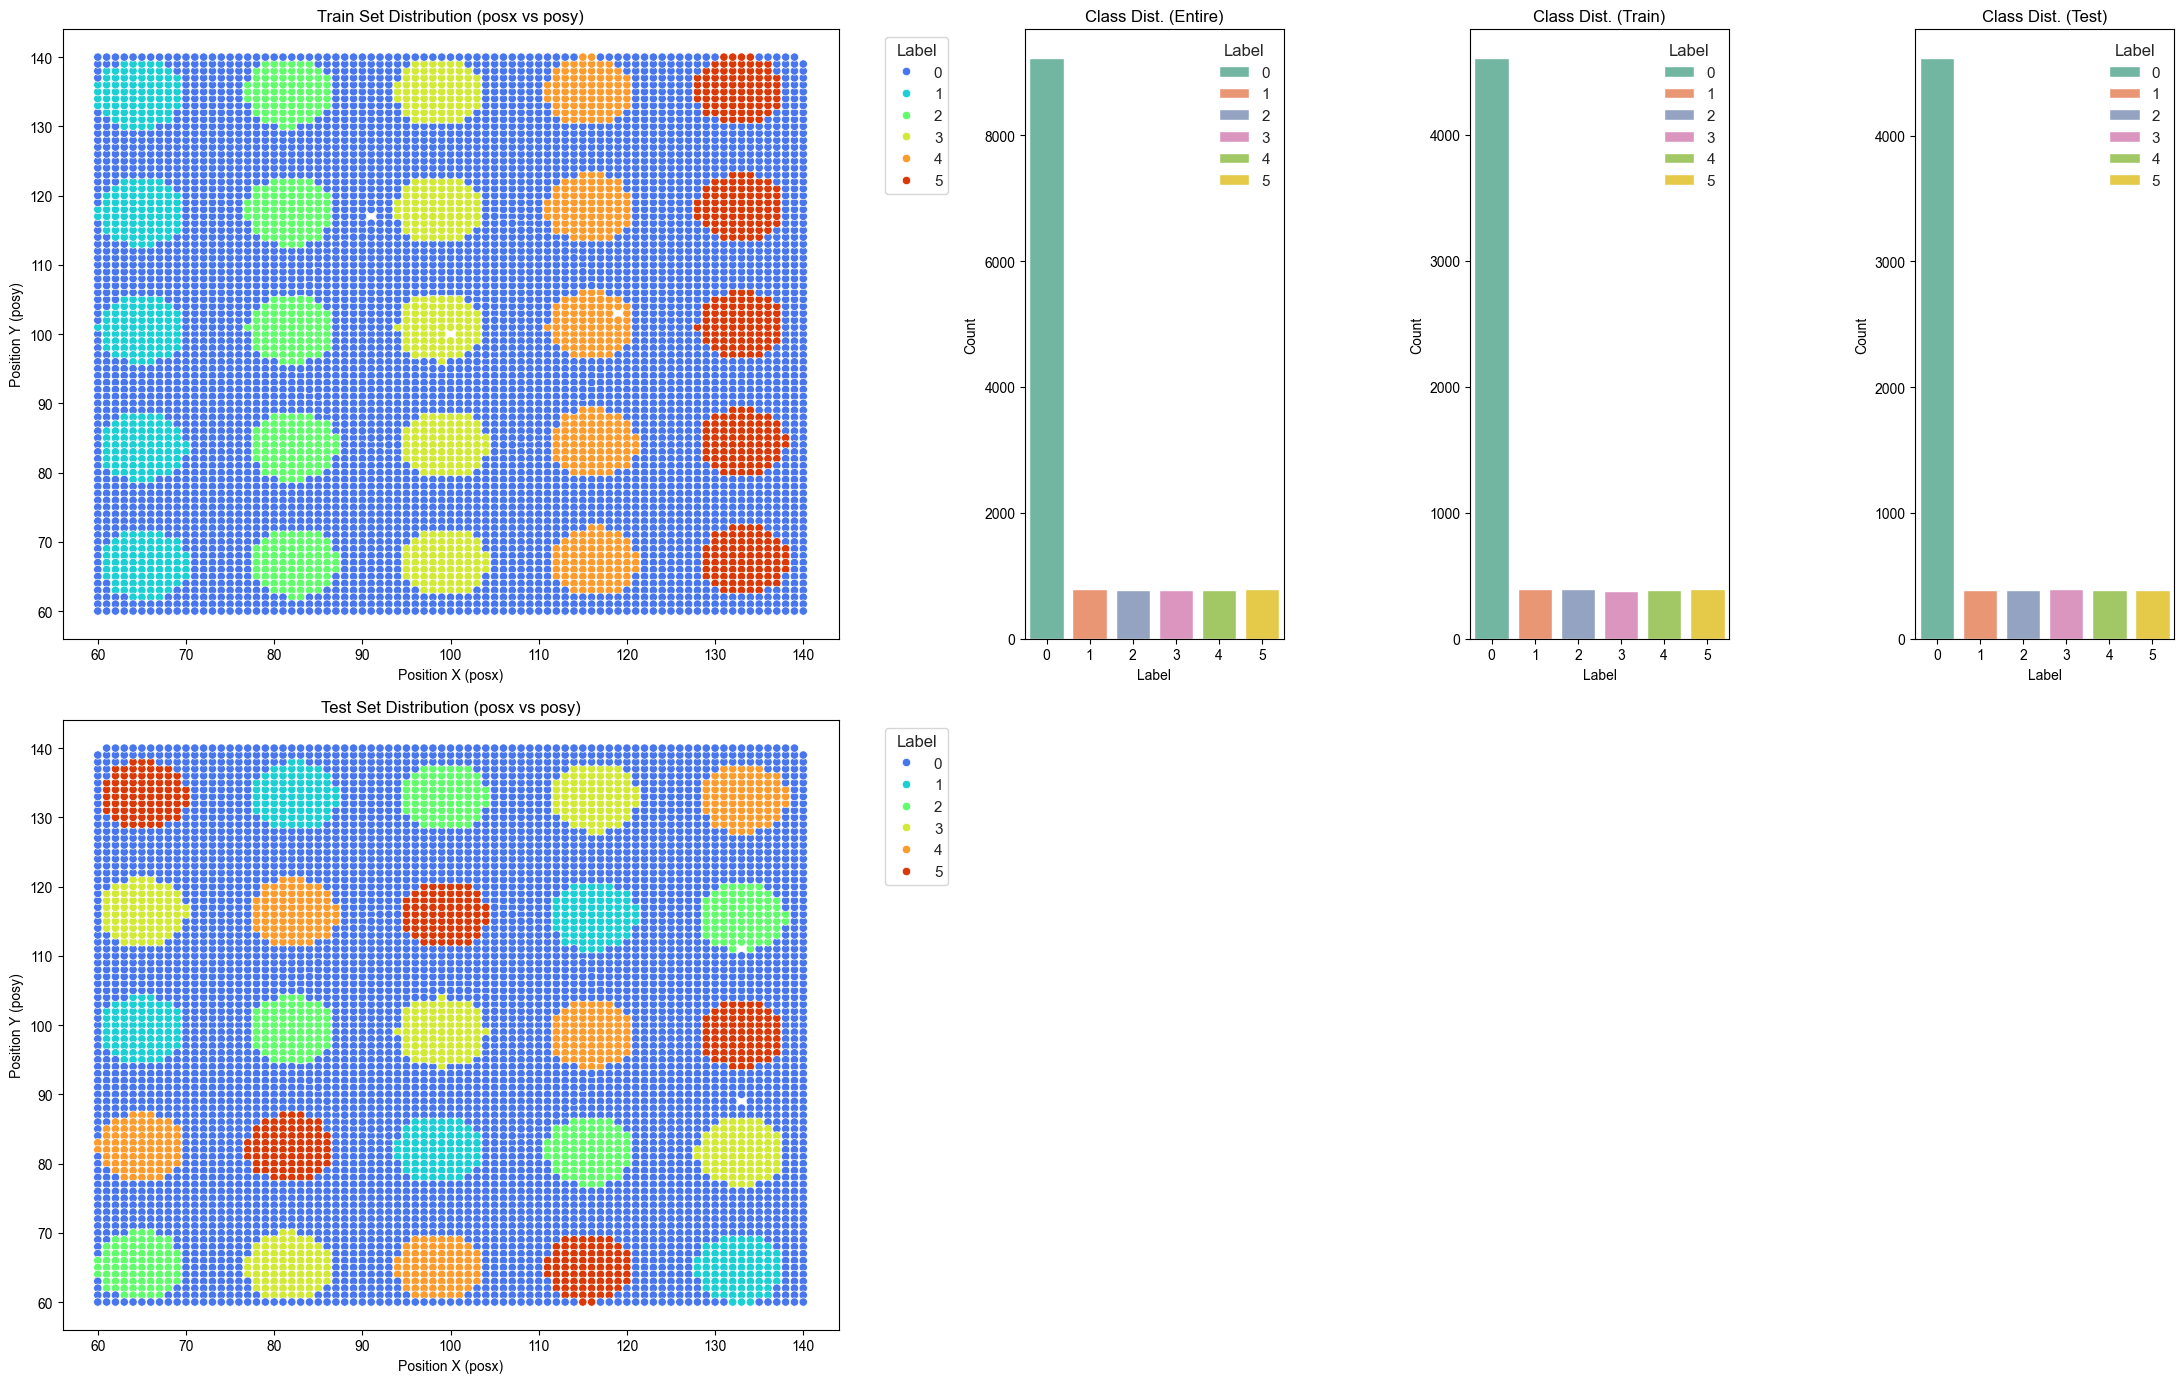

In [7]:
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Display class distribution
X = smoothed_df[feature_list + ["posx", "posy"]]
y = smoothed_df['label']

# train_df = pd.concat([train_df1, train_df2], ignore_index=True)
# smoothed_train = pd.concat([smoothed_train1, smoothed_train2], ignore_index=True)

# Training distribution:
class_distribution = Counter(smoothed_train['label'])
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Test distribution:
class_distribution = Counter(smoothed_test['label'])
print("Class distribution in the dataset:")
for label, count in sorted(class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y) * 100:.2f}%)")

# Prepare data for classification
X_train = smoothed_train[feature_list + ["posx", "posy"]]
y_train = smoothed_train['label']

X_test = smoothed_test[feature_list + ["posx", "posy"]]
y_test = smoothed_test['label']

X_validation = smoothed_validation[feature_list + ["posx", "posy"]]
y_validation = smoothed_validation['label']

# Create the figure and axes: 2 rows (train/test), then 3 histograms
fig, axs = plt.subplots(2, 4, figsize=(22, 14), gridspec_kw={'width_ratios': [3, 1, 1, 1]})

# Set style
sns.set(style="whitegrid")

# Create consistent color map using turbo
unique_labels = sorted(data_train['label'].unique())  # or union of train + test if needed
palette_colors = sns.color_palette("turbo", n_colors=len(unique_labels))
label_color_dict = {label: color for label, color in zip(unique_labels, palette_colors)}

# Plot train
sns.scatterplot(
    data=data_train,
    x='posx',
    y='posy',
    hue='label',
    palette=label_color_dict,  # Use fixed mapping
    ax=axs[0, 0]
)
axs[0, 0].set_title("Train Set Distribution (posx vs posy)")
axs[0, 0].set_xlabel("Position X (posx)")
axs[0, 0].set_ylabel("Position Y (posy)")
axs[0, 0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot test with same label-color mapping
sns.scatterplot(
    data=data_test,
    x='posx',
    y='posy',
    hue='label',
    palette=label_color_dict,  # Same dictionary ensures color consistency
    ax=axs[1, 0]
)
axs[1, 0].set_title("Test Set Distribution (posx vs posy)")
axs[1, 0].set_xlabel("Position X (posx)")
axs[1, 0].set_ylabel("Position Y (posy)")
axs[1, 0].legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Histograms / Class Distribution Plots ---
plot_class_distribution(smoothed_df['label'], axs[0, 1], "Class Dist. (Entire)")
plot_class_distribution(y_train, axs[0, 2], "Class Dist. (Train)")
plot_class_distribution(y_test, axs[0, 3], "Class Dist. (Test)")

# Hide the unused bottom row histograms
for ax in axs[1, 1:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# # Drop posx and posy columns from the training and testing sets after plotting
# X_train = X_train.drop(columns=['posx', 'posy'])
# X_test = X_test.drop(columns=['posx', 'posy'])

In [8]:
from sklearn.preprocessing import StandardScaler

scaler_train1 = StandardScaler()
scaler_train2 = StandardScaler()
scaler_test = StandardScaler()

X_train_selected = X_train[feature_list]
X_test_selected = X_test[feature_list]
X_validation_selected = X_validation[feature_list]

# X_train_selected_1 = X_train_selected[X_train["posy"] <= 140]
# X_train_selected_2 = X_train_selected[X_train["posy"] > 140]

X_train_scaled = scaler_train1.fit_transform(X_train_selected)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_list, index=X_train_selected.index)

X_validation_scaled = scaler_train1.fit_transform(X_validation_selected)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=feature_list, index=X_validation_selected.index)

# X_train_scaled2 = scaler_train2.fit_transform(X_train_selected_2)

# X_train_scaled1 = pd.DataFrame(X_train_scaled1, columns=feature_list, index=X_train_selected_1.index)
# X_train_scaled2 = pd.DataFrame(X_train_scaled2, columns=feature_list, index=X_train_selected_2.index)
# X_train_scaled = pd.concat([X_train_scaled1, X_train_scaled2]).sort_index()

X_test_scaled = scaler_test.fit_transform(X_test_selected)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_list, index=X_test_selected.index)

Plotting overall feature importance...


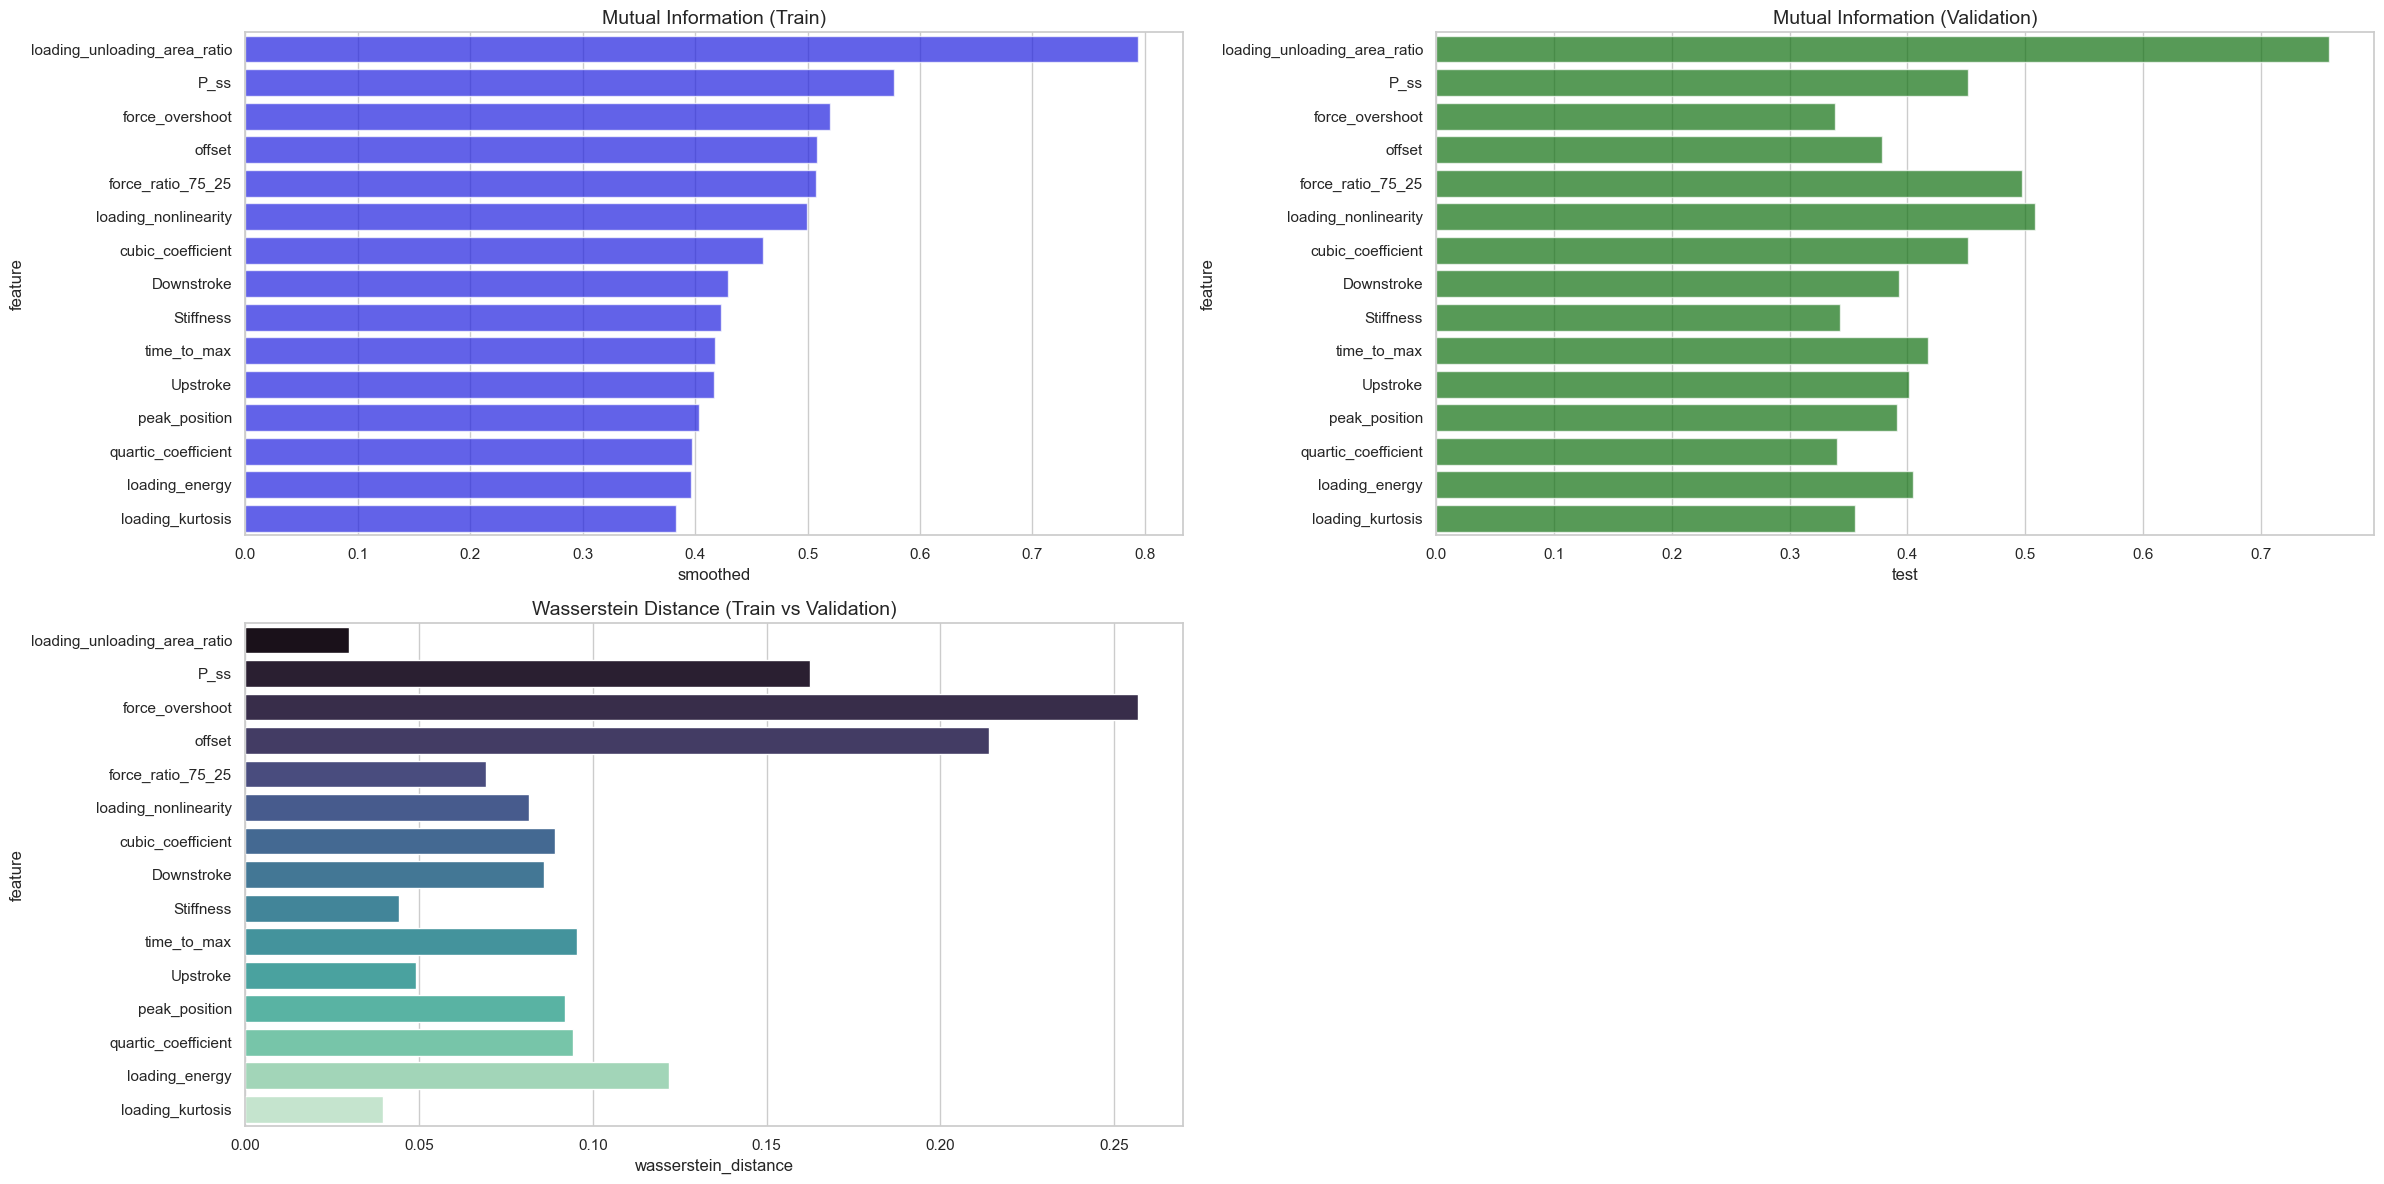

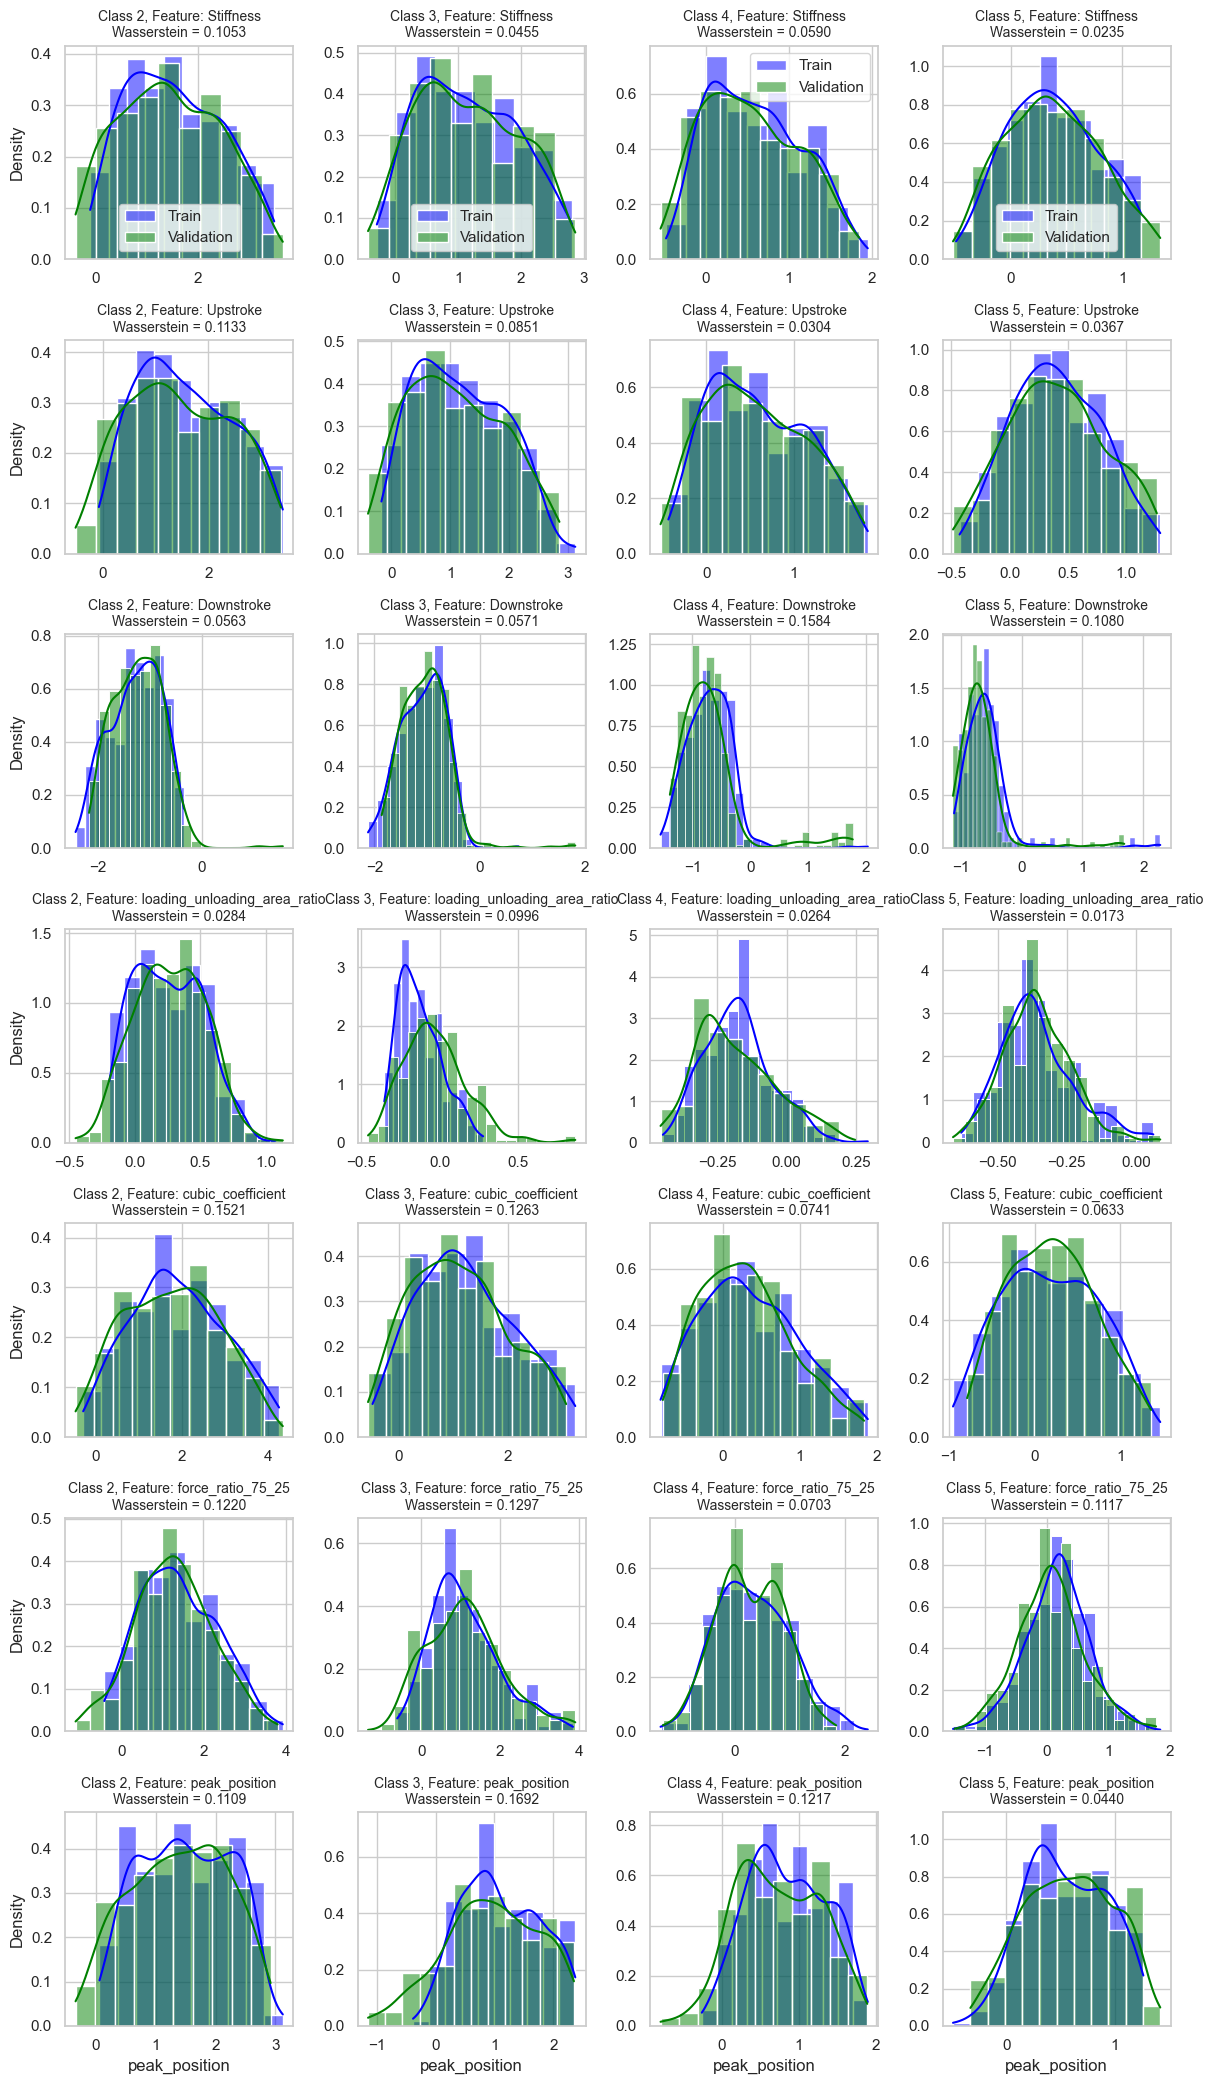


✅ Selected Features (7):
  - MI threshold: 0.3
  - Wasserstein threshold: 0.275
  - Per-class Wasserstein threshold: 0.2
  1. Stiffness
  2. Upstroke
  3. Downstroke
  4. loading_unloading_area_ratio
  5. cubic_coefficient
  6. force_ratio_75_25
  7. peak_position


In [9]:
def calculate_mutual_info(X_data, y_data, feature_list, random_state=42):
    """Calculate mutual information scores for features."""
    return mutual_info_classif(X_data[feature_list], y_data, random_state=random_state)


def calculate_wasserstein_distances(train_data, validation_data, feature_list):
    """Calculate Wasserstein distance between train and validation for each feature."""
    distances = []

    for feature in feature_list:
        distance = wasserstein_distance(train_data[feature], validation_data[feature])
        distances.append({'feature': feature, 'wasserstein_distance': distance})

    return pd.DataFrame(distances)


def calculate_distribution_metrics(train_data, validation_data, feature_list):
    """Calculate distribution metrics between train and validation sets."""
    metrics = []

    for feature in feature_list:
        # Wasserstein distance (Earth Mover's Distance)
        w_distance = wasserstein_distance(train_data[feature], validation_data[feature])

        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = ks_2samp(train_data[feature], validation_data[feature])

        metrics.append({
            'feature': feature,
            'wasserstein_distance': w_distance,
            'ks_statistic': ks_stat,
            'ks_pvalue': ks_pval
        })

    return pd.DataFrame(metrics)


def calculate_class_distribution_metrics(X_train, y_train, X_validation, y_validation, feature_list, selected_classes):
    """Calculate distribution metrics for each selected class."""
    class_metrics = {}

    for cls in selected_classes:
        # Filter data for this class
        X_train_cls = X_train[y_train == cls]
        X_val_cls = X_validation[y_validation == cls]

        # Calculate metrics for this class
        metrics_df = calculate_distribution_metrics(X_train_cls, X_val_cls, feature_list)
        class_metrics[cls] = metrics_df

    return class_metrics


def plot_feature_importance(mi_df, metrics_df, figsize=(24, 12)):
    """Plot mutual information and distribution metrics for features."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Ensure both dataframes have the same feature ordering
    mi_df = mi_df.sort_values('smoothed', ascending=False)

    # Merge to maintain the same order
    merged_df = mi_df[['feature']].merge(metrics_df, on='feature')

    # Plot Mutual Information
    sns.barplot(x='smoothed', y='feature', data=mi_df.head(15),
                color='blue', alpha=0.7, ax=axes[0, 0])
    sns.barplot(x='test', y='feature', data=mi_df.head(15),
                color='green', alpha=0.7, ax=axes[0, 1])

    axes[0, 0].set_title('Mutual Information (Train)', fontsize=14)
    axes[0, 1].set_title('Mutual Information (Validation)', fontsize=14)

    # Plot Wasserstein Distance only
    sns.barplot(x='wasserstein_distance', y='feature', data=merged_df.head(15),
                palette='mako', ax=axes[1, 0], hue='feature')
    axes[1, 0].set_title('Wasserstein Distance (Train vs Validation)', fontsize=14)

    # Turn off the unused subplot
    axes[1, 1].axis('off')

    plt.tight_layout()
    return fig


def visualize_feature_distributions(X_train, y_train, X_validation, y_validation,
                                    selected_features, selected_classes):
    figsize = (3 * len(selected_classes), 3 * len(selected_features))
    fig, axes = plt.subplots(len(selected_features), len(selected_classes), figsize=figsize)

    for i, feature in enumerate(selected_features):
        for j, cls in enumerate(selected_classes):
            ax = axes[i, j] if len(selected_features) > 1 else axes[j]

            # Filter data for the class
            train_data = X_train[y_train == cls][feature]
            val_data = X_validation[y_validation == cls][feature]

            # Plot distributions
            sns.histplot(train_data, kde=True, color='blue', alpha=0.5,
                         ax=ax, label='Train', stat='density')
            sns.histplot(val_data, kde=True, color='green', alpha=0.5,
                         ax=ax, label='Validation', stat='density')

            # Calculate Wasserstein distance for this feature and class
            w_dist = wasserstein_distance(train_data, val_data)

            ax.set_title(f"Class {cls}, Feature: {feature}\nWasserstein = {w_dist:.4f}", fontsize=10)

            if i == 0:
                ax.legend()

            if i == len(selected_features) - 1:
                ax.set_xlabel(feature)
            else:
                ax.set_xlabel('')

            if j == 0:
                ax.set_ylabel('Density')
            else:
                ax.set_ylabel('')

    plt.tight_layout()
    return fig


def select_features_advanced(mi_df, metrics_df, class_metrics, selected_classes,
                             mi_threshold=0.5, wasserstein_threshold=0.12,
                             class_wasserstein_threshold=None):
    """
    Select features based on multiple criteria:
    1. High mutual information in both train and validation
    2. Low overall distribution distances between train and validation
    3. Low per-class distribution distances
    """
    # Step 1: Filter by mutual information
    mi_selected = mi_df[(mi_df['smoothed'] > mi_threshold) &
                        (mi_df['test'] > mi_threshold)]

    # Step 2: Filter by overall distribution metrics
    dist_selected = metrics_df[metrics_df['wasserstein_distance'] < wasserstein_threshold]

    # Combine the filters
    combined = mi_selected[['feature']].merge(dist_selected[['feature']], on='feature')
    combined_features = combined['feature'].tolist()

    # Step 3: Filter by per-class distribution metrics
    if class_wasserstein_threshold is not None:
        final_features = []
        for feature in combined_features:
            ok = True
            for cls in selected_classes:
                cls_df = class_metrics[cls]
                w_dist = cls_df.loc[cls_df['feature'] == feature, 'wasserstein_distance'].values[0]
                if w_dist > class_wasserstein_threshold:
                    ok = False
                    break
            if ok:
                final_features.append(feature)
    else:
        final_features = combined_features

    return final_features


def find_best_features(X_train_scaled, y_train, X_validation_scaled, y_validation, feature_list,
                       selected_classes, mi_threshold=0.5, wasserstein_threshold=0.1,
                       class_wasserstein_threshold=None, plot=False):
    """Enhanced main function to perform feature selection analysis with per-class threshold."""
    # Filter data for selected classes
    train_mask = y_train.isin(selected_classes)
    X_train_filtered = X_train_scaled[train_mask]
    y_train_filtered = y_train[train_mask]

    test_mask = y_validation.isin(selected_classes)
    X_val_filtered = X_validation_scaled[test_mask]
    y_val_filtered = y_validation[test_mask]

    # Calculate mutual information for train and validation sets
    mi_scores_train = calculate_mutual_info(X_train_filtered, y_train_filtered, feature_list)
    mi_scores_val = calculate_mutual_info(X_val_filtered, y_val_filtered, feature_list)

    mi_df = pd.DataFrame({
        'feature': feature_list,
        'smoothed': mi_scores_train,
        'test': mi_scores_val,
    })

    # Calculate overall distribution metrics
    metrics_df = calculate_distribution_metrics(X_train_filtered, X_val_filtered, feature_list)

    # Calculate class-specific distribution metrics
    class_metrics = calculate_class_distribution_metrics(
        X_train_filtered, y_train_filtered,
        X_val_filtered, y_val_filtered,
        feature_list, selected_classes
    )

    # Select features based on enhanced criteria
    selected_features = select_features_advanced(
        mi_df, metrics_df, class_metrics, selected_classes,
        mi_threshold, wasserstein_threshold,
        class_wasserstein_threshold
    )

    if plot:
        print("Plotting overall feature importance...")
        plot_feature_importance(mi_df, metrics_df)
        plt.show()

        if len(selected_features) > 0:
            visualize_feature_distributions(
                X_train_filtered, y_train_filtered,
                X_val_filtered, y_val_filtered,
                selected_features, selected_classes
            )
            plt.show()

        print(f"\n✅ Selected Features ({len(selected_features)}):")
        print(f"  - MI threshold: {mi_threshold}")
        print(f"  - Wasserstein threshold: {wasserstein_threshold}")
        if class_wasserstein_threshold is not None:
            print(f"  - Per-class Wasserstein threshold: {class_wasserstein_threshold}")

        if len(selected_features) > 0:
            for i, feature in enumerate(selected_features, 1):
                print(f"  {i}. {feature}")
        else:
            print("  No features met all criteria. Consider relaxing thresholds.")

    return selected_features


selected_features = find_best_features(
    X_train_scaled=X_train_scaled,
    y_train=y_train,
    X_validation_scaled=X_validation_scaled,
    y_validation=y_validation,
    feature_list=feature_list_3,
    selected_classes=[2, 3, 4, 5],
    mi_threshold=0.3,
    wasserstein_threshold=0.275,
    class_wasserstein_threshold=0.2,
    plot=True
)


In [10]:
def find_best_smoothing_params(
        df,
        features_to_smooth,
        class_label_col,
        bandwidth_values,
        center_emphasis_values,
):
    """
    For each (bw,ce) in the grid, smooth the df, then compute
    silhouette_score on the smoothed feature matrix (only the smoothed
    features), using the true class labels in `class_label_col`.
    Returns a DataFrame of scores and the best (bw, ce).
    """
    results = []
    true_labels = df[class_label_col].values

    for bw in tqdm(bandwidth_values, desc="bandwidth"):
        for ce in center_emphasis_values:
            # 1) smooth
            selected_features = find_best_features(
                X_train_scaled=X_train_scaled,
                y_train=y_train,
                X_validation_scaled=X_validation_scaled,
                y_validation=y_validation,
                feature_list=features_to_smooth,
                selected_classes=[2, 3, 4, 5],
                mi_threshold=0.3,
                wasserstein_threshold=bw,
                class_wasserstein_threshold=ce
            )

            X = df[selected_features].values

            try:
                score = silhouette_score(X, true_labels)
            except ValueError:
                score = np.nan

            results.append({
                'w_th': bw,
                'cw_th': ce,
                'n_features': len(selected_features),
                'features': selected_features,
                'silhouette': score
            })

    results_df = pd.DataFrame(results)
    # pick the best
    best = results_df.loc[results_df['silhouette'].idxmax()]
    return results_df, best['w_th'], best['cw_th'], best['silhouette']


bw_vals = np.arange(0, 0.15, 0.025).tolist()
ce_vals = np.arange(0, 0.2, 0.025).tolist()
features = [f for f in feature_list if f not in ['posx', 'posy', 'label', 'class']]

df_all = pd.concat([X_train_scaled, X_validation_scaled], axis=0, ignore_index=True)
df_all['class'] = pd.concat([y_train, y_validation], axis=0, ignore_index=True)

results_df, best_bw, best_ce, best_score = find_best_smoothing_params(
    df=df_all,
    features_to_smooth=feature_list_3,
    class_label_col='class',
    bandwidth_values=bw_vals,
    center_emphasis_values=ce_vals
)

print("Best params:", best_bw, best_ce, ". silhouette:", best_score)
results_df = results_df.dropna()

# keeps the best silhouette score for equal number of features
results_df = results_df.loc[results_df.groupby('n_features')['silhouette'].idxmax()].reset_index(drop=True)
results_df = results_df[results_df["silhouette"] > 0]
results_df

bandwidth: 100%|██████████| 6/6 [01:08<00:00, 11.45s/it]

Best params: 0.05 0.125 . silhouette: 0.31718465882187064


,w_th,cw_th,n_features,features,silhouette
1,0.050,0.125,3,"[Stiffness, Upstroke, loading_unloading_area_r...",0.317185
2,0.075,0.150,4,"[Stiffness, Upstroke, loading_unloading_area_r...",0.209938
3,0.100,0.175,7,"[Stiffness, Upstroke, Downstroke, loading_unlo...",0.172512



Training Logistic Regression...
Logistic Regression Training Accuracy: 0.8815
Logistic Regression Training Balanced Accuracy: 0.8815
Logistic Regression Test Accuracy: 0.8803
Logistic Regression Test Balanced Accuracy: 0.8869


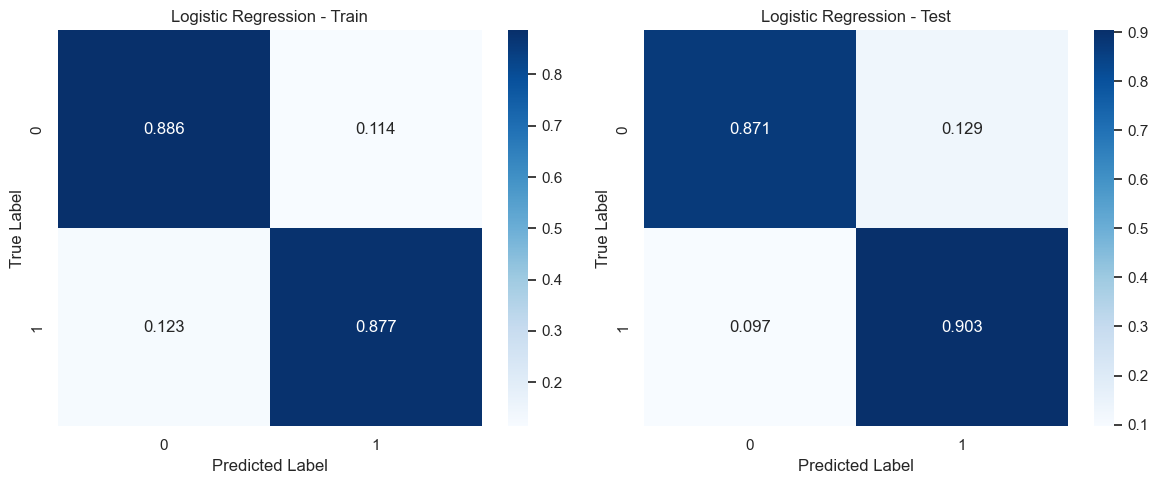

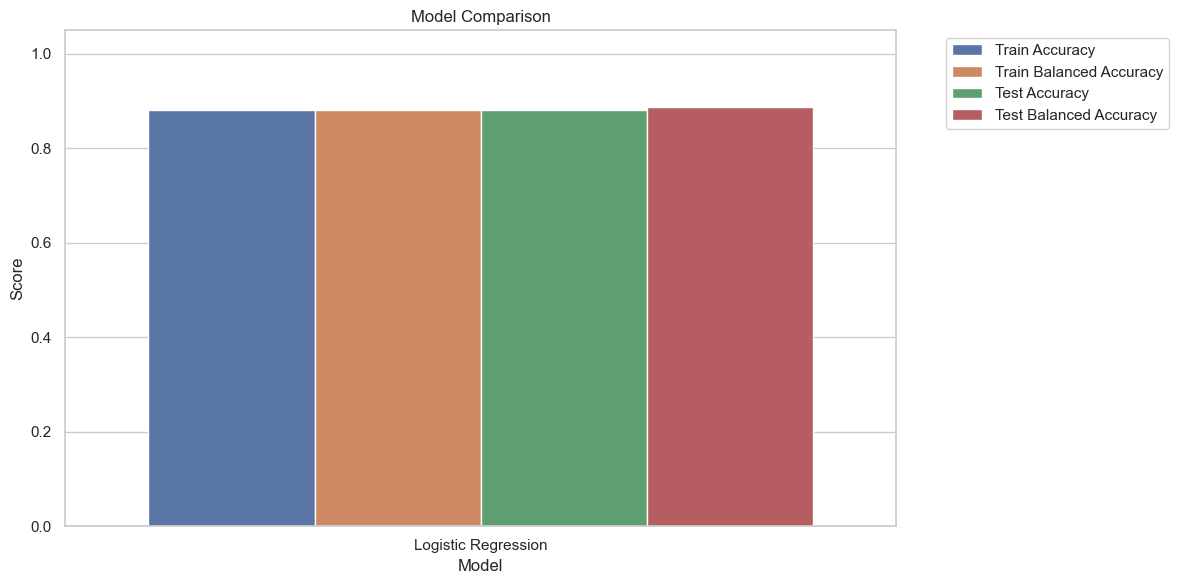





Training Logistic Regression...
Logistic Regression Training Accuracy: 0.8813
Logistic Regression Training Balanced Accuracy: 0.8813
Logistic Regression Test Accuracy: 0.8803
Logistic Regression Test Balanced Accuracy: 0.8868


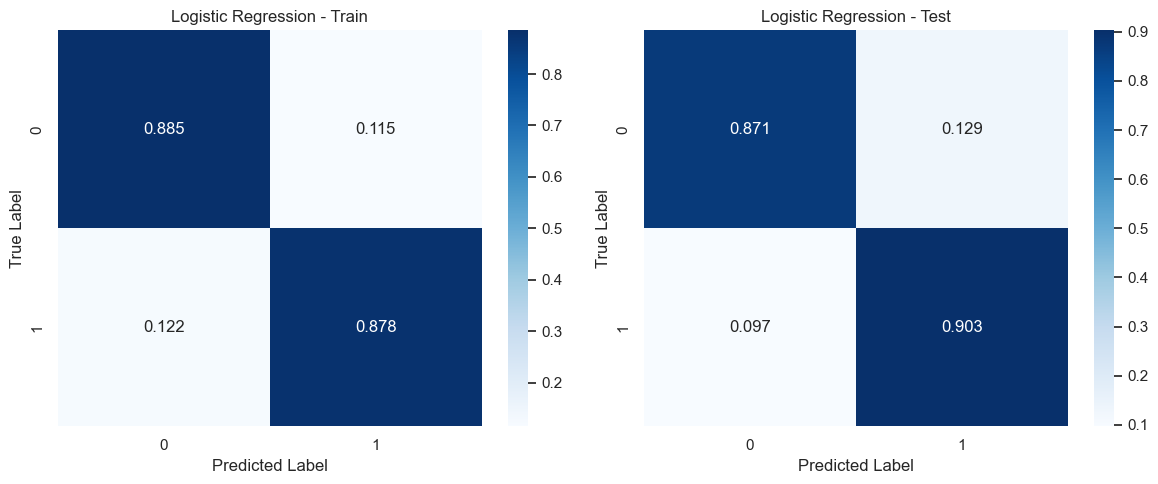

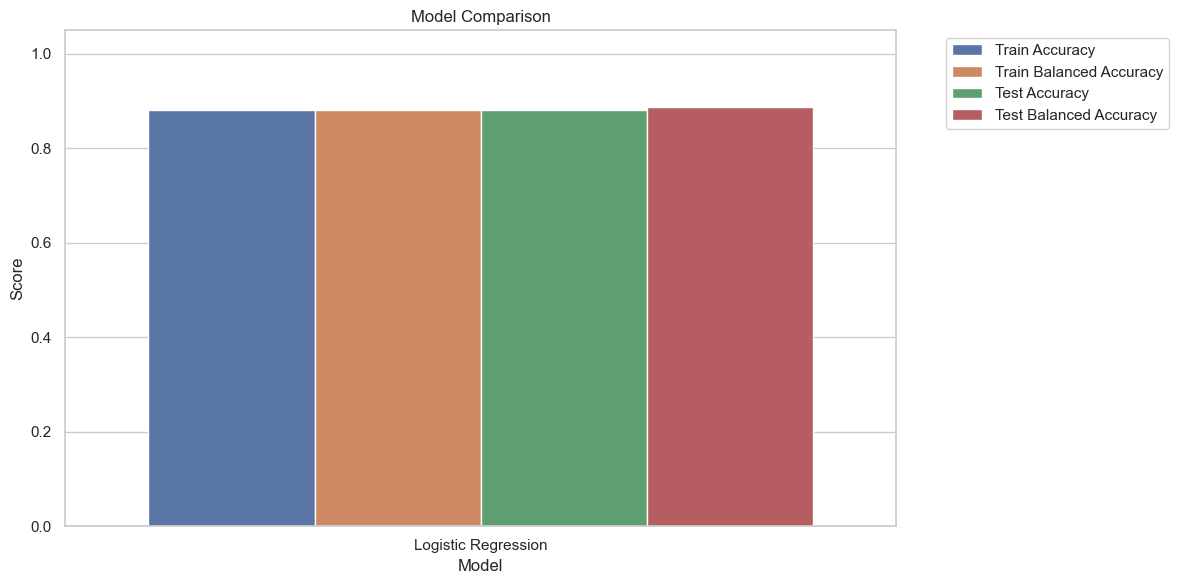





Training Logistic Regression...
Logistic Regression Training Accuracy: 0.9326
Logistic Regression Training Balanced Accuracy: 0.9324
Logistic Regression Test Accuracy: 0.8981
Logistic Regression Test Balanced Accuracy: 0.8962


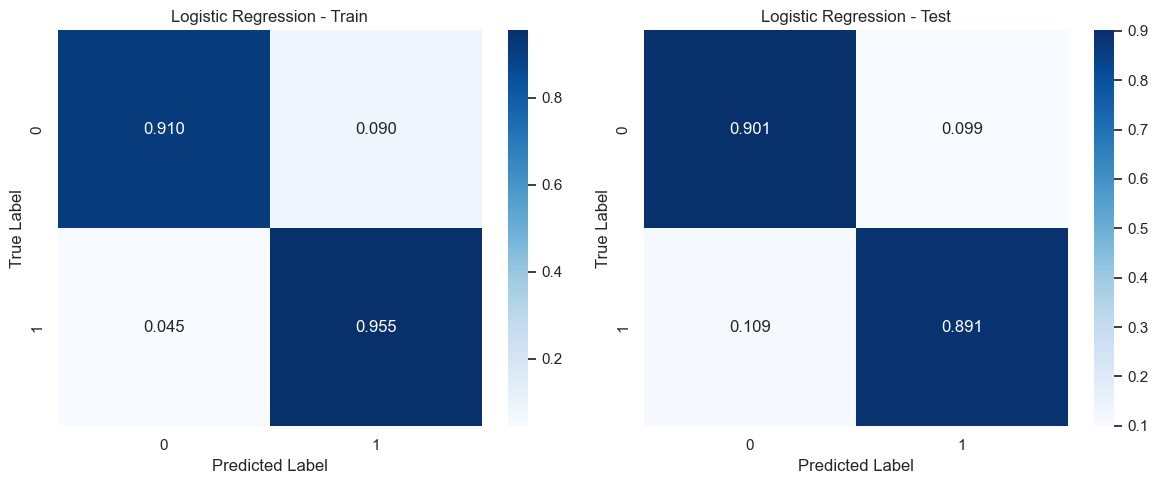

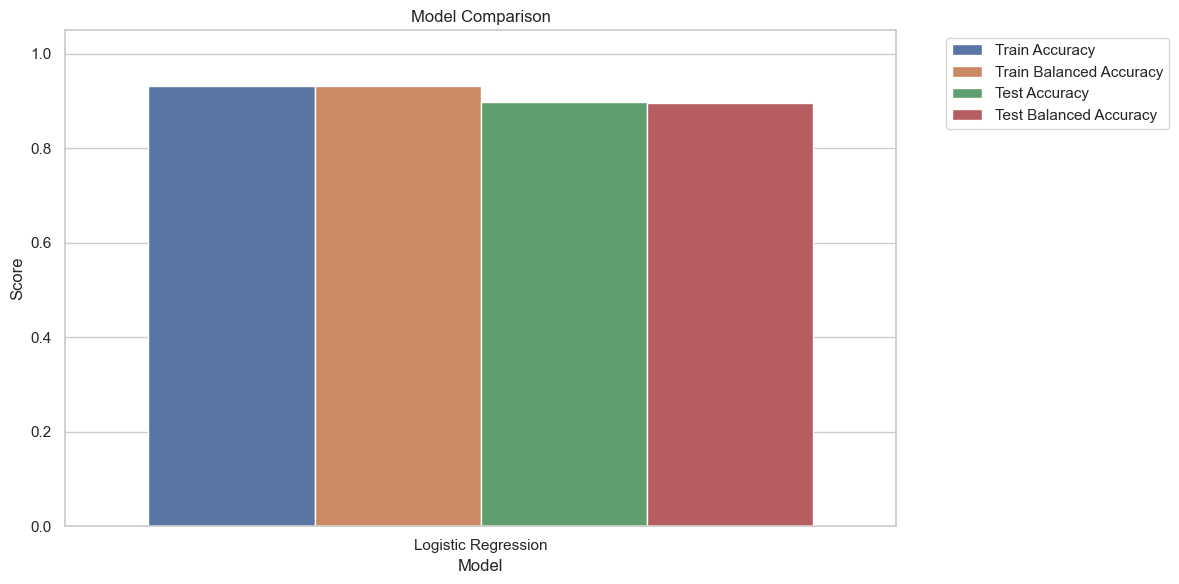

In [11]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from trainer import *

models = [
    # ('SVM', SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42)),  # n_jobs not supported
    # ('KNN', KNeighborsClassifier(n_neighbors=8, metric='minkowski', p=2, n_jobs=-1)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)),
    # ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)),
    # ('Naive Bayes', GaussianNB()),  # no n_jobs
]

# Convert labels to binary classification (0 vs all)
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Apply ADASYN for class imbalance handling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_scaled, y_train_binary)

for features_set in results_df["features"].tolist():
    X_train_selected = X_train_adasyn[features_set]
    X_test_selected = X_test_scaled[features_set]

    results = fit_and_evaluate_models(models, X_train_selected, y_train_adasyn, X_test_selected, y_test_binary)
    plot_model_comparison(results)
    print("\n\n")

In [12]:


X_train_nz = X_train_scaled.copy()
X_train_nz["label"] = y_train
X_train_nz["posy"] = X_train["posy"]
X_train_nz["posx"] = X_train["posx"]

X_test_new_nz = X_test_scaled.copy()
X_test_new_nz["label"] = y_test
X_test_new_nz["posx"] = X_test["posx"]
X_test_new_nz["posy"] = X_test["posy"]

X_val_new_nz = X_validation_scaled.copy()
X_val_new_nz["label"] = y_validation
X_val_new_nz["posx"] = X_validation["posx"]
X_val_new_nz["posy"] = X_validation["posy"]

# plot_features(X_train_nz, X_test_new_nz, feature_list)


Class distribution after ADASYN:
Label 0: 4608 samples (49.66%)
Label 1: 4671 samples (50.34%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      4613
           1       0.73      0.91      0.81      1944

    accuracy                           0.88      6557
   macro avg       0.85      0.89      0.86      6557
weighted avg       0.89      0.88      0.88      6557


Train Accuracy: 0.941, Train Balanced Accuracy: 0.941
Test Accuracy: 0.877, Test Balanced Accuracy: 0.888


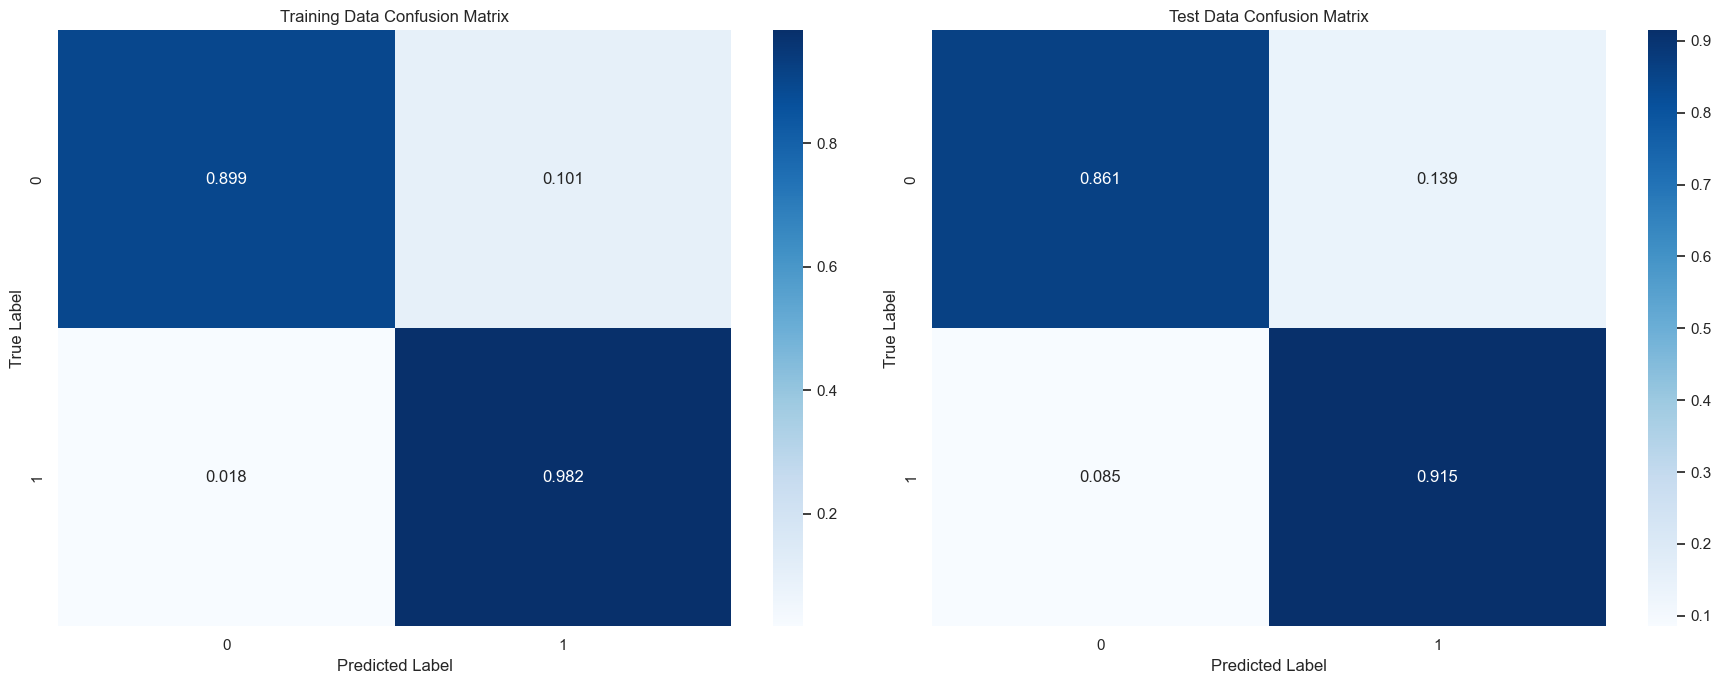

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

# Create dataset with selected features (excluding posx, posy)
# X_train_selected = X_train[feature_list]
# X_test_selected = X_test[feature_list]

feature_list = results_df["features"][2]

X_train_selected = X_train_scaled[feature_list]
X_test_selected = X_test_scaled[feature_list]
X_validation_selected = X_validation_scaled[feature_list]

# Convert labels to binary classification (0 vs all)
y_train_binary = np.where(y_train == 0, 0, 1)
y_test_binary = np.where(y_test == 0, 0, 1)

# Apply ADASYN for class imbalance handling
adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train_binary)
# X_train_adasyn, y_train_multi = X_train_selected, y_train

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model on binary data
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred = rf_model.predict(X_test_selected)

y_validation_pred = rf_model.predict(X_validation_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_binary, y_test_pred, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_binary, y_test_pred)
test_balanced_acc = balanced_accuracy_score(y_test_binary, y_test_pred)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

print(f"\nTrain Accuracy: {train_accuracy:.3f}, Train Balanced Accuracy: {train_balanced_acc:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}, Test Balanced Accuracy: {test_balanced_acc:.3f}")


# Function to create and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)  # Replace NaN with 0

    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1], ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')


# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_binary, y_test_pred, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()


In [14]:
hard_spots_test_index = y_test_pred == 1
hard_spots_test = X_test_new_nz[hard_spots_test_index]
y_test_hard = y_test[hard_spots_test_index]

hard_spots_val_index = y_validation != 0
hard_spots_validation = X_val_new_nz[hard_spots_val_index]
y_validation_hard = y_validation[hard_spots_val_index]

# y_train_pred = rf_model.predict(X_train[feature_list])
hard_spots_train_index = y_train != 0
hard_spots_train = X_train_nz[hard_spots_train_index]
y_train_hard = y_train[hard_spots_train_index]

In [15]:
from plotter import *


def grid_max_smooth(df, features_to_smooth, grid_range=1):
    """
    Efficiently smooth each feature using a 3x3 grid around each point.
    """
    df_smoothed = df.copy()

    # Create a spatial index - a dictionary mapping (x,y) to row index position O(1) - instead of repeated search
    spatial_index = {}
    for i, (idx, row) in enumerate(df.iterrows()):
        spatial_index[(row['posx'], row['posy'])] = i

    # Process each feature
    for feature in features_to_smooth:
        if feature not in df.columns or feature in ['posx', 'posy', 'label']:
            continue

        feature_values = df[feature].values  # Cache the feature values array
        smoothed_values = np.empty_like(feature_values)

        # For each position in the original dataframe
        for i, (idx, row) in enumerate(df.iterrows()):
            x, y = row['posx'], row['posy']
            grid_values = []

            # Check each cell in the 3x3 grid
            for dx in range(-grid_range, grid_range + 1):
                for dy in range(-grid_range, grid_range + 1):
                    # Use the spatial index for direct lookup
                    grid_pos = (x + dx, y + dy)
                    if grid_pos in spatial_index:
                        pos = spatial_index[grid_pos]
                        grid_values.append(feature_values[pos])

            # Take the maximum of the values found in the grid
            smoothed_values[i] = max(grid_values) if grid_values else feature_values[i]

        # Assign all values at once
        df_smoothed[feature] = smoothed_values

    return df_smoothed


# Apply kNN median smoothing to train set
hard_spots_train_smoothed = grid_max_smooth(
    hard_spots_train,
    feature_list,
)

# Apply kNN median smoothing to test set
hard_spots_test_smoothed = grid_max_smooth(
    hard_spots_test,
    feature_list,
)

# Apply kNN median smoothing to validation set
hard_spots_validation_smoothed = grid_max_smooth(
    hard_spots_validation,
    feature_list,
)

# # Visualize the smoothing effect for each feature
# for feature in feature_list:
#     plot_smoothing_effect(
#         hard_spots_test,
#         hard_spots_test_smoothed,
#         hard_spots_train,
#         hard_spots_train_smoothed,
#         feature
#     )


### Full Classifier


Class distribution after ADASYN:
Label 1: 395 samples (20.26%)
Label 2: 391 samples (20.05%)
Label 3: 378 samples (19.38%)
Label 4: 390 samples (20.00%)
Label 5: 396 samples (20.31%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       643
           1       0.79      1.00      0.88       387
           2       0.46      0.56      0.50       384
           3       0.32      0.33      0.33       387
           4       0.31      0.55      0.39       330
           5       0.36      0.58      0.44       290

    accuracy                           0.45      2421
   macro avg       0.37      0.50      0.43      2421
weighted avg       0.34      0.45      0.38      2421



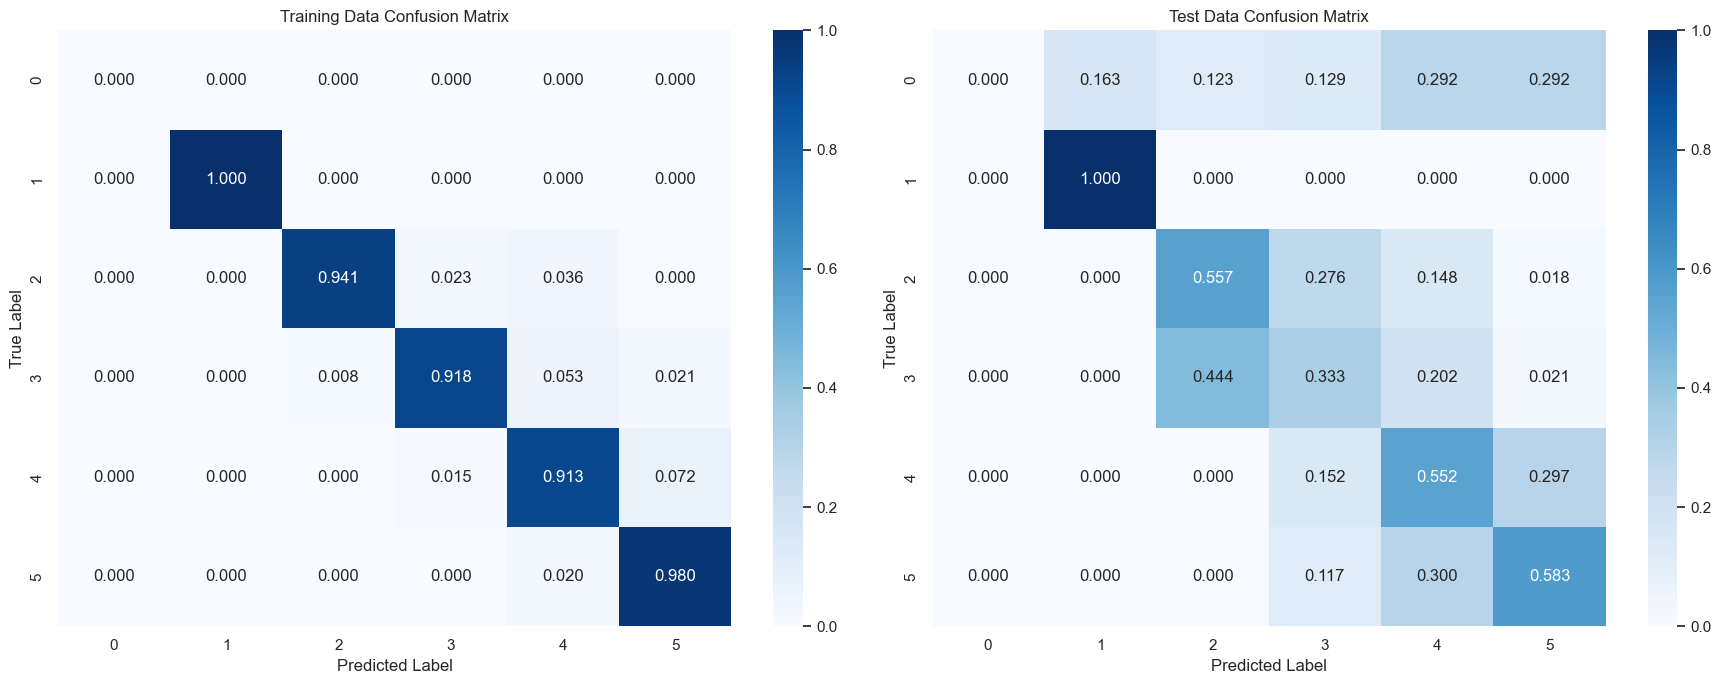

In [16]:
from plotter import plot_confusion_matrix

# test_index = y_test_pred == 1
# X_test_new_nz = X_test_new[test_index]
# y_test_nz = y_test[test_index]
#
# train_index = y_train != 0
# X_train_nz = X_train[train_index]
# y_train_nz = y_train[train_index]
#
# X_train_selected = X_train_nz[feature_list]
# X_test_selected = X_test_new_nz[feature_list]  #X_test  --- X_test_new

X_train_selected = hard_spots_train_smoothed[feature_list]
X_test_selected = hard_spots_test_smoothed[feature_list]
y_train_nz = y_train_hard
y_test_nz = y_test_hard

# Apply ADASYN for adaptive oversampling
# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred_nz = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_nz, y_test_pred_nz, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_nz, y_test_pred_nz)
test_balanced_acc = balanced_accuracy_score(y_test_nz, y_test_pred_nz)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_nz, y_test_pred_nz, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()



Class distribution after ADASYN:
Label 1: 395 samples (20.26%)
Label 2: 391 samples (20.05%)
Label 3: 378 samples (19.38%)
Label 4: 390 samples (20.00%)
Label 5: 396 samples (20.31%)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       643
           1       0.79      0.98      0.87       387
           2       0.44      0.60      0.51       384
           3       0.33      0.44      0.37       387
           4       0.24      0.43      0.31       330
           5       0.30      0.33      0.32       290

    accuracy                           0.42      2421
   macro avg       0.35      0.46      0.40      2421
weighted avg       0.32      0.42      0.36      2421



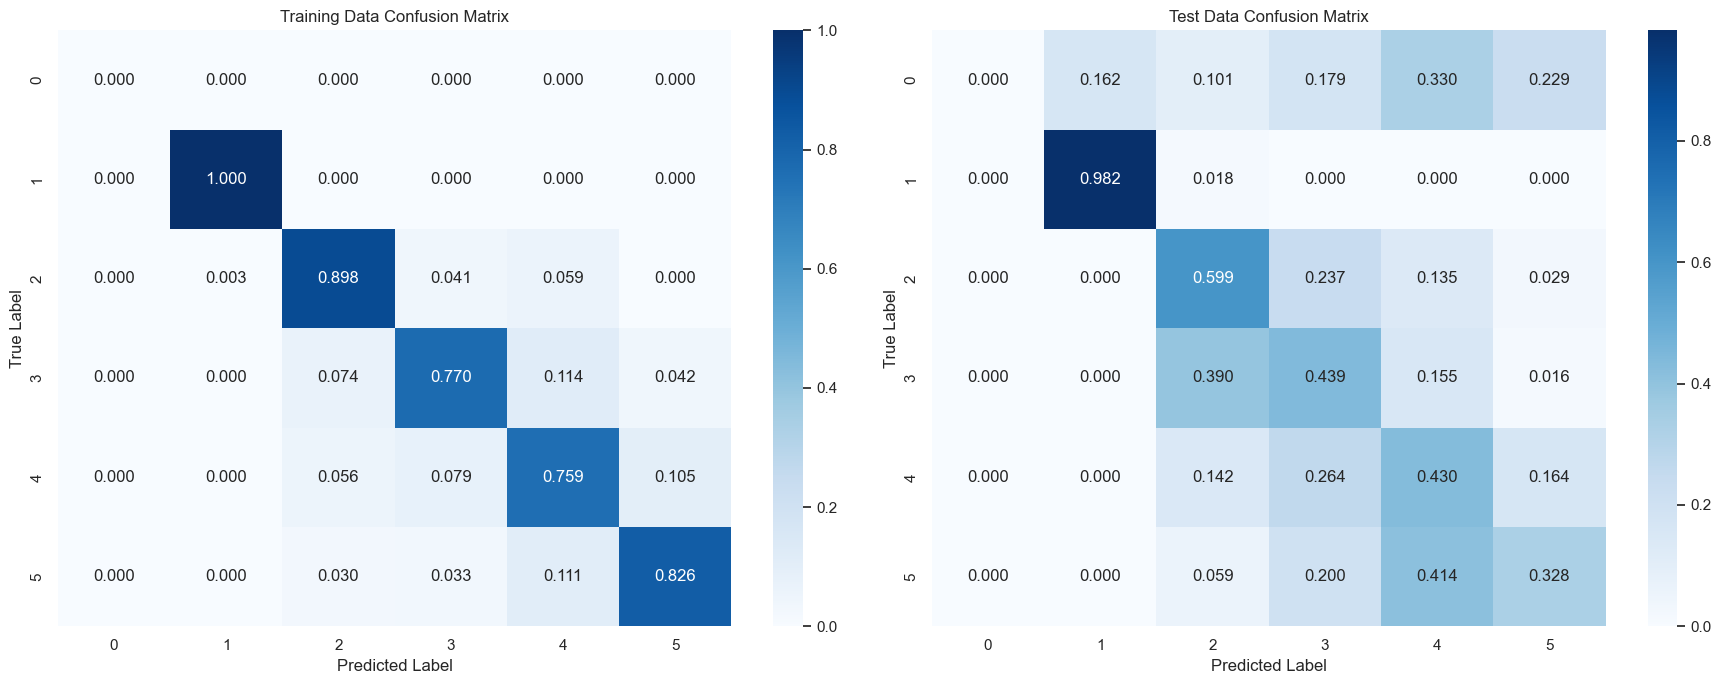

In [17]:
from plotter import plot_confusion_matrix

test_index = y_test_pred == 1
X_test_new_nz = X_test_scaled[test_index]
y_test_nz = y_test[test_index]

train_index = y_train != 0
X_train_nz = X_train_scaled[train_index]
y_train_nz = y_train[train_index]

X_train_selected = X_train_nz[feature_list]
X_test_selected = X_test_new_nz[feature_list]  #X_test  --- X_test_new

# X_train_selected = hard_spots_train_smoothed[feature_list]
# X_test_selected = hard_spots_test_smoothed[feature_list]
# y_train_nz = y_train_hard
# y_test_nz = y_test_hard

# Apply ADASYN for adaptive oversampling
# adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=5)
# X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

X_train_adasyn, y_train_adasyn = X_train_selected, y_train_nz

# Display new class distribution after ADASYN
adasyn_class_distribution = Counter(y_train_adasyn)
print("\nClass distribution after ADASYN:")
for label, count in sorted(adasyn_class_distribution.items()):
    print(f"Label {label}: {count} samples ({count / len(y_train_adasyn) * 100:.2f}%)")

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=5,
    bootstrap=True,
    criterion='entropy',
    class_weight=None,
    random_state=42,
    max_features=0.5,
    n_jobs=-1,
)

# Fit the model
rf_model.fit(X_train_adasyn, y_train_adasyn)

# Make predictions on training data
y_train_pred = rf_model.predict(X_train_adasyn)

# Make predictions on test data
y_test_pred_nz = rf_model.predict(X_test_selected)

# Evaluate the model on test data
print("\nClassification Report (Test Data):")
print(classification_report(y_test_nz, y_test_pred_nz, zero_division=0))

# Calculate performance metrics
test_accuracy = accuracy_score(y_test_nz, y_test_pred_nz)
test_balanced_acc = balanced_accuracy_score(y_test_nz, y_test_pred_nz)
train_accuracy = accuracy_score(y_train_adasyn, y_train_pred)
train_balanced_acc = balanced_accuracy_score(y_train_adasyn, y_train_pred)

# Create a figure with two subplots for the confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot confusion matrices for training and test data
plot_confusion_matrix(y_train_adasyn, y_train_pred, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_test_nz, y_test_pred_nz, 'Test Data Confusion Matrix', ax2)

plt.tight_layout()
plt.show()


In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
import numpy as np


class TwoStageClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, binary_model=None, multiclass_model=None, features=None, train_smoothed=None):
        self.binary_model = binary_model
        self.multiclass_model = multiclass_model
        self.features = features
        self.train_smoothed = train_smoothed

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y_binary = (y != 0).astype(int)
        mask = y != 0

        adasyn = ADASYN(sampling_strategy='auto', random_state=42, n_neighbors=10)
        X_adasyn, y_binary_adasyn = adasyn.fit_resample(X[self.features], y_binary)

        self.binary_model_ = clone(self.binary_model)
        self.binary_model_.fit(X_adasyn, y_binary_adasyn)

        self.multiclass_model_ = clone(self.multiclass_model)
        y_multiclass = y[mask] - 1

        if len(self.train_smoothed[0]) == len(y_multiclass):
            X_hard_smoothed = self.train_smoothed[0][self.features]
        else:
            X_hard_smoothed = self.train_smoothed[1][self.features]

        self.multiclass_model_.fit(X_hard_smoothed, y_multiclass)
        return self

    def predict(self, X):
        binary_preds = self.binary_model_.predict(X[self.features])
        idx = binary_preds == 1

        X_hard_smoothed = grid_max_smooth(
            X[idx],
            self.features
        )

        final_preds = np.zeros(X.shape[0], dtype=int)
        if np.any(idx):
            final_preds[idx] = self.multiclass_model_.predict(X_hard_smoothed[self.features]) + 1

        return final_preds



In [19]:
# List of model hyperparameters definitions
models = [
    {
        'model': SVC(kernel='rbf'),
        'hyperparameters': {
            'C': [20, 25, 30],
            'gamma': [0.06, 0.1, 0.2],
        }
    },
    {
        'model': RandomForestClassifier(n_jobs=-1, bootstrap=True, criterion='entropy', max_features=0.5,
                                        n_estimators=200),
        'hyperparameters': {
            'max_depth': [None],
            'min_samples_split': [6, 10, 15],
            'min_samples_leaf': [5, 8]
        }
    }
    #   {
    #         'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    #         'hyperparameters': {
    #             'n_estimators': [100, 200],
    #             'max_depth': [4, 6],
    #             'gamma': [i / 10.0 for i in range(0, 4)]
    #         }
    #     }
]

from itertools import product


# Function to generate all combinations of binary and multiclass classifiers
def generate_combinations(models):
    combinations = []

    # Generate combinations for binary and multiclass model pairs
    for binary_model, multiclass_model in product(models, repeat=2):
        binary_model_params = binary_model['hyperparameters']
        multiclass_model_params = multiclass_model['hyperparameters']

        # Construct a dict for each combination
        param_dict = {
            'binary_model': [binary_model['model']],
            **{f'binary_model__{k}': v for k, v in binary_model_params.items()},
            'multiclass_model': [multiclass_model['model']],
            **{f'multiclass_model__{k}': v for k, v in multiclass_model_params.items()},
            'features': list(results_df['features'])
        }

        combinations.append(param_dict)

    return combinations


# Generate the combinations
param_grid = generate_combinations(models)
param_grid


[{'binary_model': [SVC()],
  'binary_model__C': [20, 25, 30],
  'binary_model__gamma': [0.06, 0.1, 0.2],
  'multiclass_model': [SVC()],
  'multiclass_model__C': [20, 25, 30],
  'multiclass_model__gamma': [0.06, 0.1, 0.2],
  'features': [['Stiffness', 'Upstroke', 'loading_unloading_area_ratio'],
   ['Stiffness',
    'Upstroke',
    'loading_unloading_area_ratio',
    'force_ratio_75_25'],
   ['Stiffness',
    'Upstroke',
    'Downstroke',
    'loading_unloading_area_ratio',
    'cubic_coefficient',
    'force_ratio_75_25',
    'peak_position']]},
 {'binary_model': [SVC()],
  'binary_model__C': [20, 25, 30],
  'binary_model__gamma': [0.06, 0.1, 0.2],
  'multiclass_model': [RandomForestClassifier(criterion='entropy', max_features=0.5, n_estimators=200,
                          n_jobs=-1)],
  'multiclass_model__max_depth': [None],
  'multiclass_model__min_samples_split': [6, 10, 15],
  'multiclass_model__min_samples_leaf': [5, 8],
  'features': [['Stiffness', 'Upstroke', 'loading_unloadin

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

clf = TwoStageClassifier(train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed])

X_train_final = X_train_scaled.copy()
X_train_final["posy"] = X_train["posy"]
X_train_final["posx"] = X_train["posx"]

X_test_final = X_test_scaled.copy()
X_test_final["posx"] = X_test["posx"]
X_test_final["posy"] = X_test["posy"]

X_val_final = X_validation_scaled.copy()
X_val_final["posx"] = X_validation["posx"]
X_val_final["posy"] = X_validation["posy"]

X_train_val = pd.concat([X_train_final, X_val_final], axis=0)
y_train_val = pd.concat([y_train, y_validation], axis=0)

test_fold = [0] * len(X_train_final) + [1] * len(X_val_final)
ps = PredefinedSplit(test_fold)

grid_search = GridSearchCV(
    clf,
    param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    error_score='raise',
    cv=ps,
    n_jobs=-1,
    refit=False,
    verbose=3
)

grid_search.fit(X_train_val, y_train_val)
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 2 folds for each of 675 candidates, totalling 1350 fits
Best Params: {'binary_model': RandomForestClassifier(criterion='entropy', max_features=0.5, n_estimators=200,
                       n_jobs=-1), 'binary_model__max_depth': None, 'binary_model__min_samples_leaf': 5, 'binary_model__min_samples_split': 15, 'features': ['Stiffness', 'Upstroke', 'Downstroke', 'loading_unloading_area_ratio', 'cubic_coefficient', 'force_ratio_75_25', 'peak_position'], 'multiclass_model': SVC(), 'multiclass_model__C': 25, 'multiclass_model__gamma': 0.1}
Best Score: 0.7162478851518499



=== Test Metrics ===
Accuracy:  0.8200
F1 Score (macro):  0.6230

=== Validation Metrics ===
Accuracy:  0.8588
F1 Score (macro):  0.7440


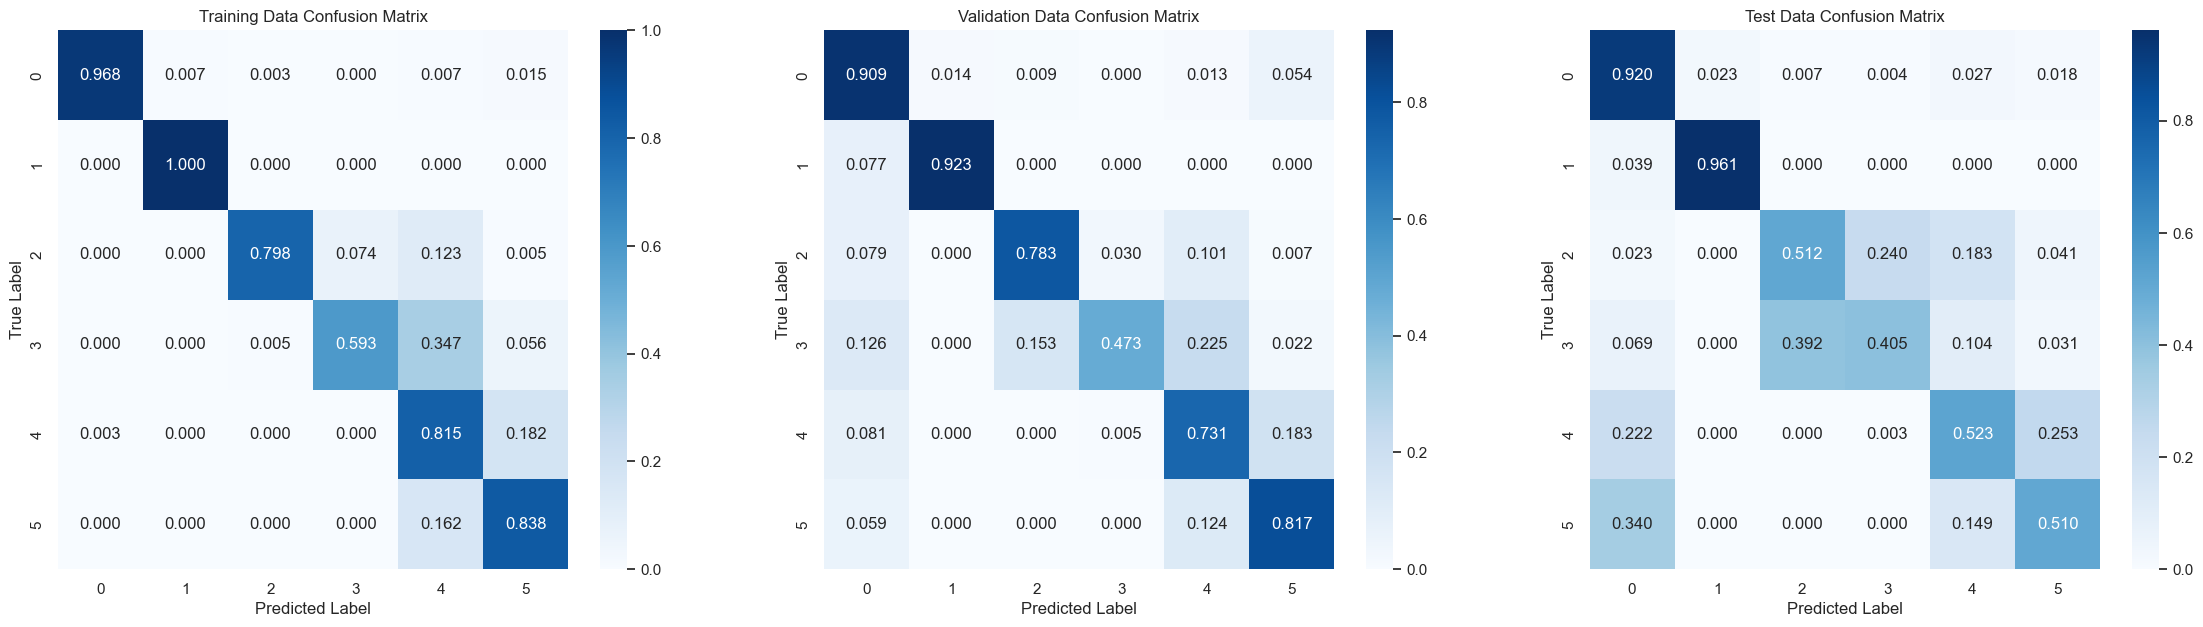

In [21]:



def print_metrics(y_true, y_pred, label="Set"):
    print(f"\n=== {label} Metrics ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")


# Get the best parameters
best_params = grid_search.best_params_

# Create base estimators
binary_model = clone(best_params['binary_model'])
multiclass_model = clone(best_params['multiclass_model'])
best_features = best_params['features'] + ["posx", "posy"]

# Apply parameters to the two models
for param, value in best_params.items():
    if param.startswith('binary_model__'):
        param_name = param.replace('binary_model__', '')
        setattr(binary_model, param_name, value)
    if param.startswith('multiclass_model__'):
        param_name = param.replace('multiclass_model__', '')
        setattr(multiclass_model, param_name, value)

# Create classifier with the configured models
best_clf = TwoStageClassifier(
    binary_model=binary_model,
    multiclass_model=multiclass_model,
    features=best_params['features'],
    train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed]
)

# Now fit and evaluate as before
best_clf.fit(X_train_final[best_features], y_train)

# Make predictions
y_pred_test = best_clf.predict(X_test_final[best_features])
y_pred_train = best_clf.predict(X_train_final[best_features])
y_pred_val = best_clf.predict(X_val_final[best_features])

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 7))
plot_confusion_matrix(y_train, y_pred_train, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_validation, y_pred_val, 'Validation Data Confusion Matrix', ax2)
plot_confusion_matrix(y_test, y_pred_test, 'Test Data Confusion Matrix', ax3)
S
# Print performance metrics
print_metrics(y_test, y_pred_test, label="Test")
print_metrics(y_validation, y_pred_val, label="Validation")


=== Test Metrics ===
Accuracy:  0.8194
F1 Score (macro):  0.6220

=== Validation Metrics ===
Accuracy:  0.8582
F1 Score (macro):  0.7438


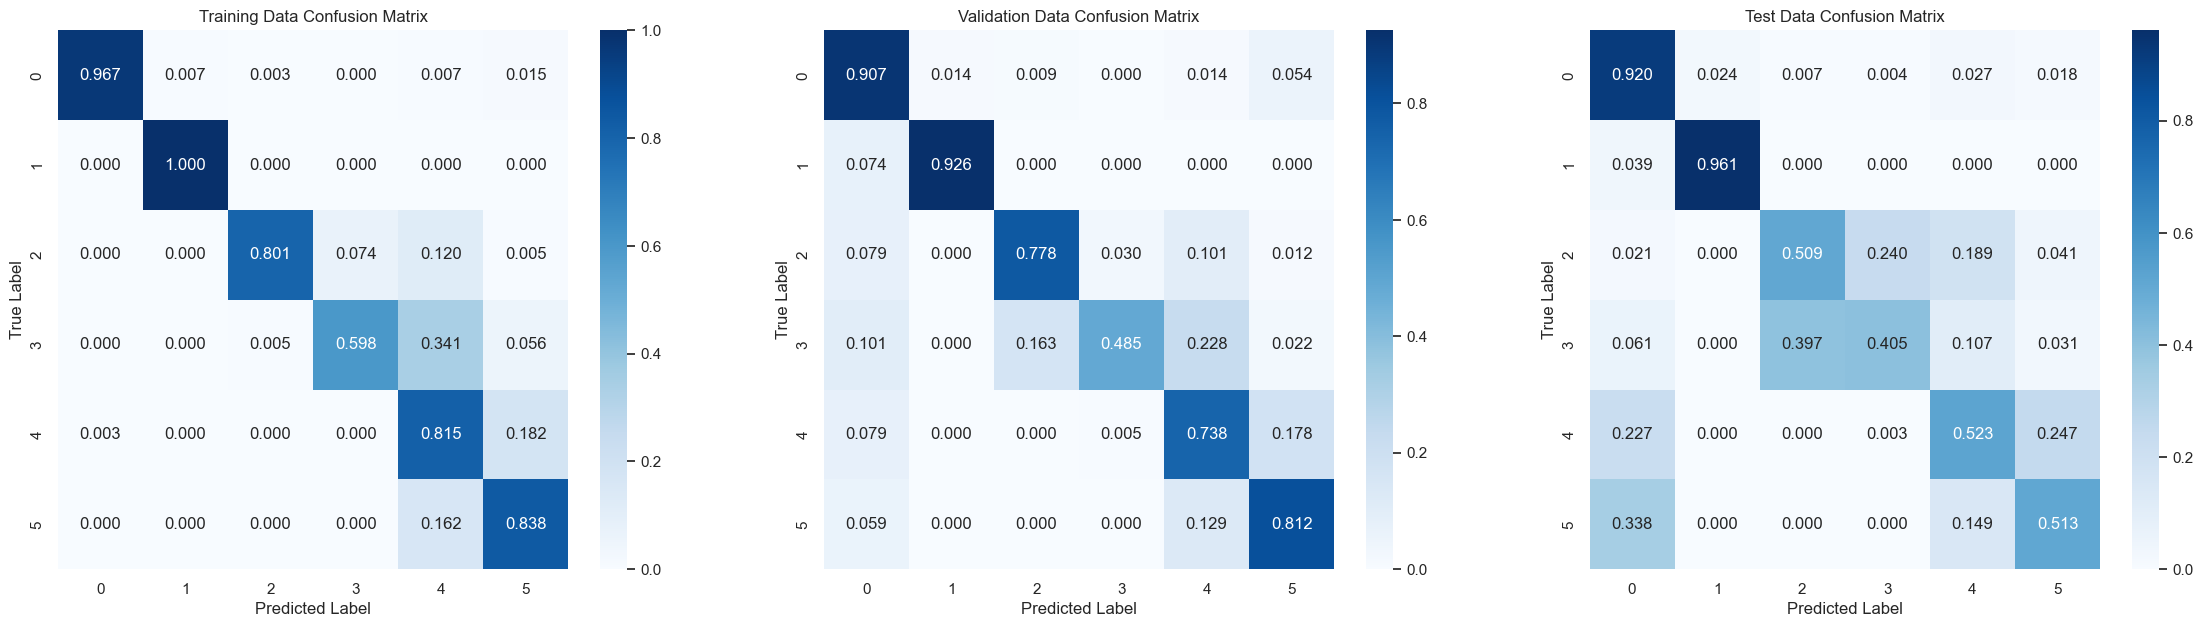

In [22]:
from sklearn.metrics import accuracy_score, f1_score


def print_metrics(y_true, y_pred, label="Set"):
    print(f"\n=== {label} Metrics ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")


# Get the best parameters
best_params = grid_search.best_params_

# Create base estimators
binary_model = clone(best_params['binary_model'])
multiclass_model = clone(best_params['multiclass_model'])
best_features = best_params['features'] + ["posx", "posy"]

# Apply parameters to the two models
for param, value in best_params.items():
    if param.startswith('binary_model__'):
        param_name = param.replace('binary_model__', '')
        setattr(binary_model, param_name, value)
    if param.startswith('multiclass_model__'):
        param_name = param.replace('multiclass_model__', '')
        setattr(multiclass_model, param_name, value)

setattr(binary_model, "max_depth", None)


# Create classifier with the configured models
best_clf = TwoStageClassifier(
    binary_model=binary_model,
    multiclass_model=multiclass_model,
    features=best_params['features'],
    train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed]
)

# Now fit and evaluate as before
best_clf.fit(X_train_final[best_features], y_train)

# Make predictions
y_pred_test = best_clf.predict(X_test_final[best_features])
y_pred_train = best_clf.predict(X_train_final[best_features])
y_pred_val = best_clf.predict(X_val_final[best_features])

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 7))
plot_confusion_matrix(y_train, y_pred_train, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_validation, y_pred_val, 'Validation Data Confusion Matrix', ax2)
plot_confusion_matrix(y_test, y_pred_test, 'Test Data Confusion Matrix', ax3)

# Print performance metrics
print_metrics(y_test, y_pred_test, label="Test")
print_metrics(y_validation, y_pred_val, label="Validation")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\brill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\brill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

AttributeError: _ARRAY_API not found

  0%|          | 0/656 [00:00<?, ?it/s]

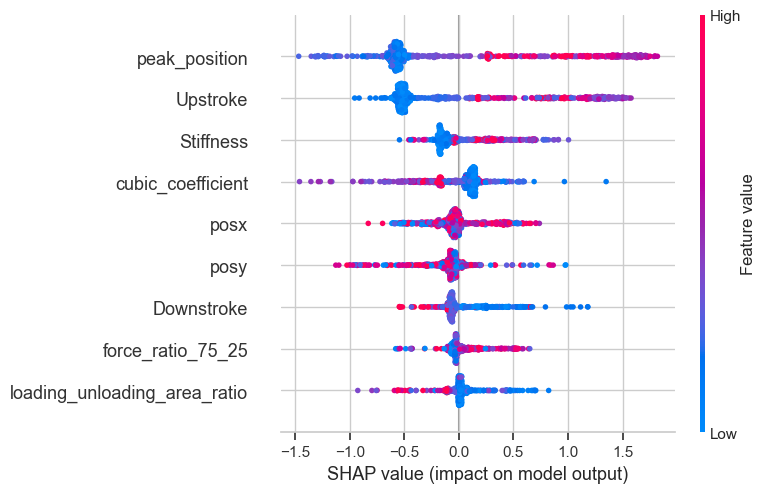

In [23]:
import shap
import pandas as pd
import numpy as np

# -------------------------------------------------------------------
# 1) Prepare: feature list & background
# -------------------------------------------------------------------

bg_df = X_train_final[best_features].sample(frac=0.01, random_state=38)
bg_np = bg_df.to_numpy()

# -------------------------------------------------------------------
# 2) Wrap predict to accept NumPy arrays
# -------------------------------------------------------------------

def wrapped_predict(arr):  # because it uses np array by default
    df = pd.DataFrame(arr, columns=best_features)
    return best_clf.predict(df)

# -------------------------------------------------------------------
# 3) Create SHAP KernelExplainer and compute values
# -------------------------------------------------------------------

explainer = shap.KernelExplainer(wrapped_predict, bg_np)
# test_np   = X_test_final[best_features].to_numpy()
test_sample = X_test_final[best_features].sample(frac=0.1, random_state=42)
test_np = test_sample.to_numpy()

# nsamples trades off speed vs. accuracy
shap_values = explainer.shap_values(test_np)

# -------------------------------------------------------------------
# 4) Plot the SHAP summary plot
# -------------------------------------------------------------------

shap.summary_plot(
    shap_values,
    test_np,
    feature_names=best_features
)